In [108]:
# Load packages

import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
from scipy.stats import gaussian_kde
import corner
import pandas as pd

plt.rcParams['figure.dpi'] = 100
mpl.rcParams.update({'font.size': 14})

In [116]:
# First let's get all of the local SAM galaxies to compare our most extreme galaxy to

sam_dir = '/mnt/ceph/users/lperez/AGNmodelingSCSAM/sam_newAGNcode_allzs_Sophie/h5files'
#sam_dir = '/mnt/ceph/users/lperez/CAMELS-SAM-phot/CV/CV_1/fid-sam_oldAGN/h5files'
sv = "0_0_0"

with h5py.File(f'{sam_dir}/volume.hdf5', 'r') as f:
    group = f[f"{sv}/Galprop"]

    # Load redshift first to make the mask
    redshift = group['GalpropRedshift'][:]
    redshift_mask = (redshift >= 0) & (redshift < 0.1)

    # Load only the subset you need using the mask
    stellar_mass = group['GalpropMstar'][:][redshift_mask] * 1e9 # Msolar
    bh_mass = group['GalpropMBH'][:][redshift_mask] * 1e9 # Msolar
    metal_mass = group['GalpropZstar'][:][redshift_mask] * 1e9 # Msolar Zsolar, metal mass in total stellar mass
    cold_mass = group['GalpropZcold'][:][redshift_mask] * 1e9 # Msolar Zsolar, metal mass in total cold gas
    hi_mass = group['GalpropMHI'][:][redshift_mask] * 1e9 # Msolar
    h2_mass = group['GalpropMH2'][:][redshift_mask] * 1e9 # Msolar
    bulge_mass = group['GalpropMbulge'][:][redshift_mask] * 1e9 # Msolar
    disk_radius = group['GalpropRdisk'][:][redshift_mask] # kpc
    halo_radius = group['GalpropRhalo'][:][redshift_mask] # Mpc
    gas_mass = group['GalpropMcold'][:][redshift_mask] * 1e9 # Msolar, total cold gas mass
    redshift = redshift[redshift_mask]
    stellar_mass_merge = group['GalpropMstar_merge'][:][redshift_mask] * 1e9 # Msolar
    maccdot = group['GalpropMaccdot_bright'][:][redshift_mask]
    halo_mass = group['GalpropMhalo'][:][redshift_mask] * 1e9 # Msolar
    outflow_rate_mass = group['GalpropOutflowRate_Mass'][:][redshift_mask] # Msolar/yr
    outflow_rate_metal = group['GalpropOutflowRate_Metal'][:][redshift_mask] # Msolar/yr
    fric_radius = group['GalpropRfric'][:][redshift_mask] # kpc
    sfr = group['GalpropSFR'][:][redshift_mask] # Msolar/yr
    t_merger = group['GalpropTmerger'][:][redshift_mask] # Gyr
    t_merger_major = group['GalpropTmerger_major'][:][redshift_mask] # Gyr
    sat_type = group['GalpropSatType'][:][redshift_mask] # 0 - central, 1 - satellite

# Compute derived properties

# gas metallicity
Z_gas = cold_mass / gas_mass # Zsolar

# stellar metallicity
Z_star = metal_mass / stellar_mass

# cold gas fraction 
f_cold = (hi_mass + h2_mass)/(stellar_mass)

# disk radius -> gas radius
gas_radius = disk_radius * 1.68 * 2 # kpc

# Av 
cosine_incs = 1
k_v = 3.4822e4  # cm^2/g
log_Av_values = np.log(4.4e-3) - np.log(cosine_incs) + np.log(k_v) + np.log(metal_mass / 1e10) - 2*np.log(disk_radius)
Av_values = np.exp(log_Av_values)

/tmp/ipykernel_2278099/2825131773.py:40: RuntimeWarning: divide by zero encountered in divide
  Z_gas = cold_mass / gas_mass # Zsolar
/tmp/ipykernel_2278099/2825131773.py:40: RuntimeWarning: invalid value encountered in divide
  Z_gas = cold_mass / gas_mass # Zsolar


In [3]:
# Get the index of the most extreme galaxy
index = np.argmax(Av_values)
print("Index of galaxy with largest Av:", index)
print('-----')
print("log(Av) =", np.log10(Av_values[index]))
print("Stellar mass =", stellar_mass[index], 'Msolar')
print("Disk radius =", disk_radius[index], 'kpc')
print("Gas mass =", gas_mass[index], 'Msolar')
print("Metal mass =", metal_mass[index], 'Msolar Zsolar')
print("Zgas =", Z_gas[index], 'Zsolar')
print("Redshift =", redshift[index])

Index of galaxy with largest Av: 134124
-----
log(Av) = 6.750701240034627
Stellar mass = 1.0162e+11 Msolar
Disk radius = 0.0215816 kpc
Gas mass = 3.39531e+08 Msolar
Metal mass = 1.71223e+11 Msolar Zsolar
Zgas = 1.0226046 Zsolar
Redshift = 0.0723861


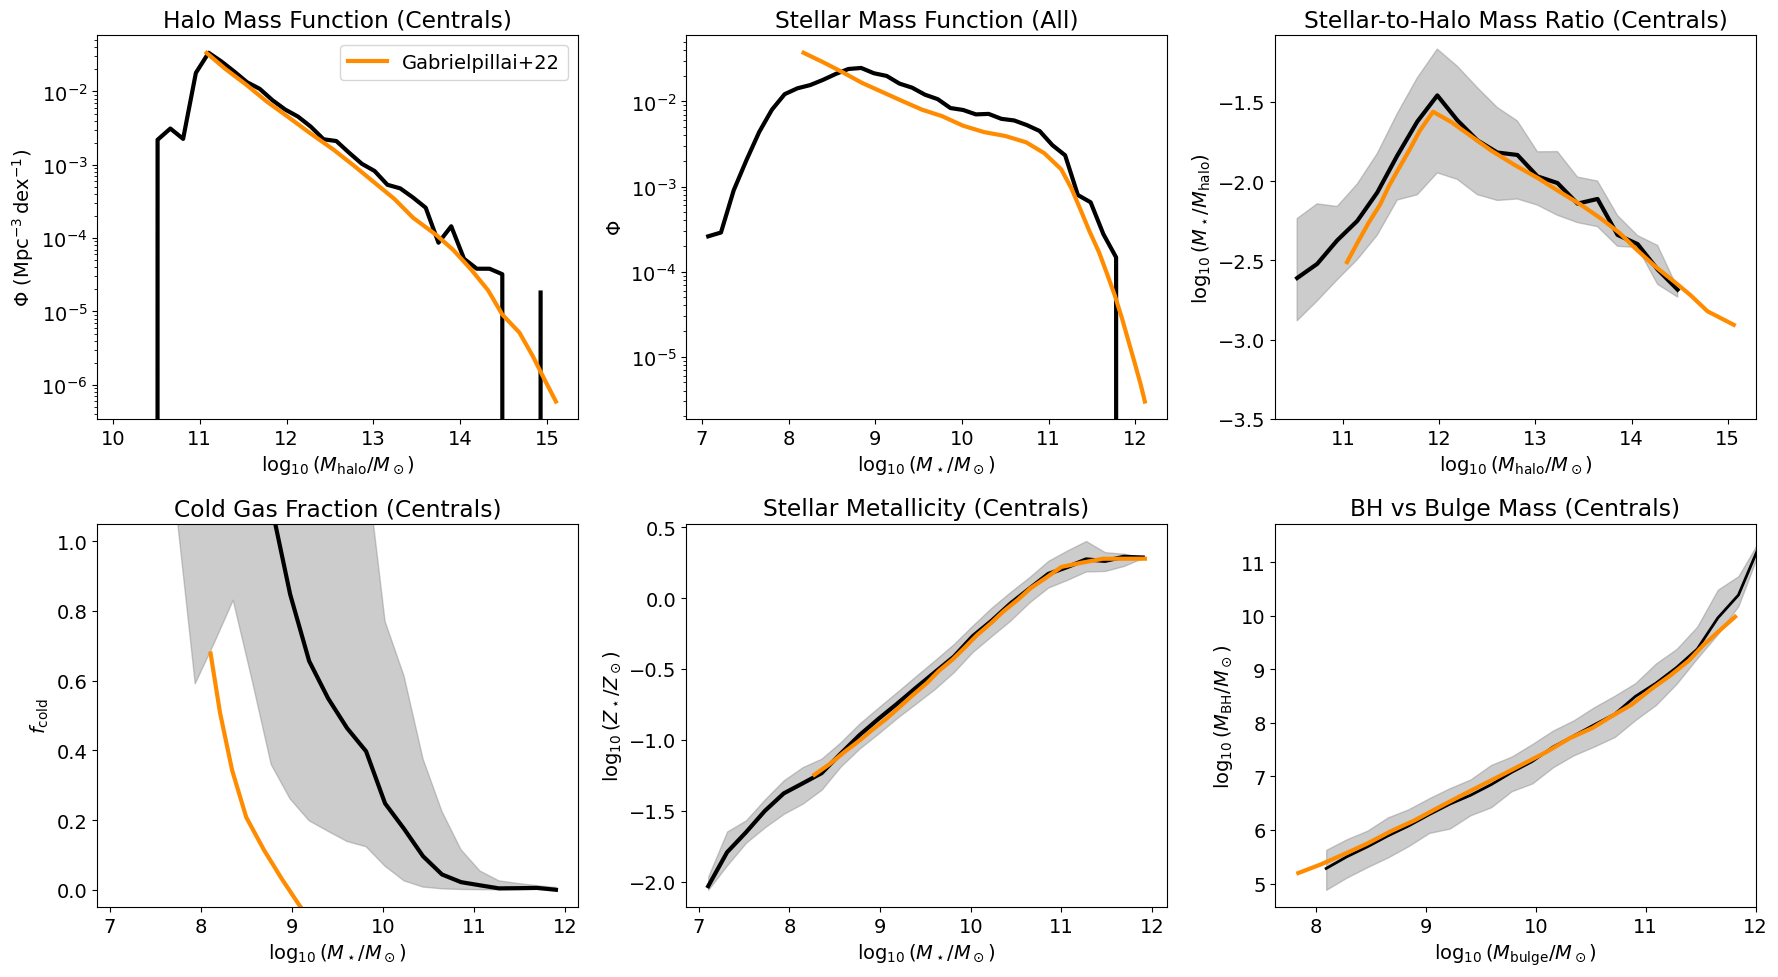

In [86]:
volume = 150**3 # Mpc^3 
ok_halo = (halo_mass > 0) 
ok_star = (stellar_mass > 0) 
is_central = (sat_type == 0) 
gab_color = 'darkorange'

def binned_median(x, y, bins, p16=16, p84=84):
    """Compute median and 16–84 percentile in bins."""
    med, p16v, p84v = np.zeros(len(bins)-1), np.zeros(len(bins)-1), np.zeros(len(bins)-1)
    for i in range(len(bins)-1):
        mask = (x >= bins[i]) & (x < bins[i+1])
        if np.any(mask):
            med[i] = np.median(y[mask])
            p16v[i] = np.percentile(y[mask], p16)
            p84v[i] = np.percentile(y[mask], p84)
        else:
            med[i] = np.nan
            p16v[i] = np.nan
            p84v[i] = np.nan
    centers = 0.5 * (bins[:-1] + bins[1:])
    return centers, med, p16v, p84v

def plot_median(ax, x, y, color='steelblue', label=None, bins=None, logx=True, logy=True):
    """Plot median and shaded percentile band."""
    mask = np.isfinite(x) & np.isfinite(y)
    x, y = x[mask], y[mask]
    
    # define bins if not provided
    if bins is None:
        if logx:
            bins = np.logspace(np.log10(np.nanmin(x)), np.log10(np.nanmax(x)), 25)
        else:
            bins = np.linspace(np.nanmin(x), np.nanmax(x), 25)
    
    centers, med, p16v, p84v = binned_median(x, y, bins)
    
    if logx:
        ax.set_xscale('log')
    if logy:
        ax.set_yscale('log')
    
    ax.plot(centers, med, color=color, lw=2, label=label)
    ax.fill_between(centers, p16v, p84v, color=color, alpha=0.3)

# Set up figure
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

# -----------------------------
# 1) Phi vs log10(Mhalo) (centrals)
gab1 = np.array([
    [11.079297522512434, -1.4752475247524748],
    [11.295506473724297, -1.6930693069306928],
    [11.538864746203128, -1.91089108910891],
    [11.773128444066128, -2.1386138613861387],
    [12.016531517405134, -2.346534653465346],
    [12.277944536535102, -2.5742574257425743],
    [12.539402356525246, -2.7920792079207915],
    [12.77371085524842, -3.0099009900990095],
    [13.00797455311142, -3.2376237623762365],
    [13.24223825097442, -3.465346534653465],
    [13.458267998745576, -3.7227722772277216],
    [13.728685990771023, -3.96039603960396],
    [13.917835222436272, -4.158415841584159],
    [14.124770395591597, -4.425742574257425],
    [14.322566193270912, -4.712871287128713],
    [14.483983692486895, -5.03960396039604],
    [14.681958693606918, -5.2871287128712865],
    [14.834371219927423, -5.603960396039604],
    [14.968684198736616, -5.920792079207921],
    [15.103041978405985, -6.22772277227723],
])
gab_x1, gab_y1 = gab1[:,0], 10**gab1[:,1]

mask = ok_halo & is_central
bins = np.linspace(10, 15, 35)
log_mhalo = np.log10(halo_mass[mask])
counts, edges = np.histogram(log_mhalo, bins=bins)
bin_width = edges[1]-edges[0]
phi = counts/(volume*bin_width)
centers = 0.5*(edges[:-1]+edges[1:])
ax = axes[0]
ax.plot(centers, phi, color='k', lw=3)
ax.plot(gab_x1, gab_y1, color=gab_color, lw=3, label='Gabrielpillai+22')
ax.set_yscale('log')
ax.set_xlabel(r'$\log_{10}(M_{\rm halo}/M_\odot)$')
ax.set_ylabel(r'$\Phi\ (\mathrm{Mpc^{-3}\,dex^{-1}})$')
ax.set_title('Halo Mass Function (Centrals)')
ax.legend()

# -----------------------------
# 2) Phi vs log10(Mstar) (all galaxies)
gab2 = np.array([
    [8.17361111111111, -1.4285714285714284],
    [8.402777777777777, -1.5413533834586461],
    [8.618055555555555, -1.6541353383458643],
    [8.847222222222221, -1.781954887218045],
    [9.076388888888888, -1.8872180451127827],
    [9.305555555555555, -1.9924812030075194],
    [9.541666666666666, -2.097744360902256],
    [9.770833333333332, -2.172932330827068],
    [10.013888888888888, -2.2857142857142856],
    [10.256944444444445, -2.360902255639098],
    [10.5, -2.4060150375939853],
    [10.743055555555555, -2.4812030075187974],
    [10.95138888888889, -2.6090225563909777],
    [11.145833333333332, -2.796992481203008],
    [11.263888888888888, -3.022556390977444],
    [11.368055555555555, -3.2706766917293235],
    [11.472222222222221, -3.526315789473684],
    [11.583333333333334, -3.7744360902255645],
    [11.67361111111111, -4.022556390977443],
    [11.76388888888889, -4.2781954887218046],
    [11.847222222222221, -4.548872180451128],
    [11.916666666666666, -4.796992481203007],
    [11.98611111111111, -5.04511278195489],
    [12.0625, -5.3233082706766925],
    [12.11111111111111, -5.526315789473686],
])
gab_x2, gab_y2 = gab2[:,0], 10**gab2[:,1]

mask = ok_star
bins = np.linspace(7, 12, 35)
log_mstar = np.log10(stellar_mass[mask])
counts, edges = np.histogram(log_mstar, bins=bins)
bin_width = edges[1]-edges[0]
phi = counts/(volume*bin_width)
centers = 0.5*(edges[:-1]+edges[1:])
ax = axes[1]
ax.plot(centers, phi, color='k', lw=3)
ax.plot(gab_x2, gab_y2, color=gab_color, lw=3)
ax.set_yscale('log')
ax.set_xlabel(r'$\log_{10}(M_\star/M_\odot)$')
ax.set_ylabel(r'$\Phi$')
ax.set_title('Stellar Mass Function (All)')

# -----------------------------
# 3) log10(Mstar/Mhalo) vs log10(Mhalo)
gab3 = np.array([
    [11.0398789353551, -2.511286965440267],
    [11.143105650018603, -2.3949985419955553],
    [11.263506651516828, -2.2646227790570226],
    [11.383827211390535, -2.148364521221506],
    [11.478527113855066, -2.0285316386964434],
    [11.573126464288947, -1.9263456375501502],
    [11.693507355381042, -1.7994992508873713],
    [11.796734070044545, -1.68321082744266],
    [11.934168585534586, -1.563453358940584],
    [12.121838895536495, -1.6273139536052927],
    [12.317935465706732, -1.7123658887291227],
    [12.53961247247388, -1.8080512010940057],
    [12.78695035746247, -1.9002523855969267],
    [13.025801651064343, -1.9818503584679887],
    [13.239012176850911, -2.063403082925259],
    [13.469296437441555, -2.148515349267478],
    [13.673939930216891, -2.233582367195905],
    [13.87852309177384, -2.3292375139515937],
    [14.057405154297092, -2.4354355411207522],
    [14.244854249831576, -2.5381192748187544],
    [14.449417300982393, -2.6373037978501968],
    [14.61134629113835, -2.718766025479884],
    [14.790248464067732, -2.8214346763732885],
    [15.063267337683884, -2.9066223567384935],
])
gab_x3, gab_y3 = gab3[:,0], gab3[:,1]

mask = ok_halo & ok_star & is_central
x = np.log10(halo_mass[mask])
y = np.log10(stellar_mass[mask]/halo_mass[mask])
bins = np.linspace(10, 15, 25)
centers, med, p16, p84 = binned_median(x, y, bins)
ax = axes[2]
ax.plot(centers, med, color='k', lw=3)
ax.fill_between(centers, p16, p84, color='gray', alpha=0.4)
ax.plot(gab_x3, gab_y3, color=gab_color, lw=3)
ax.set_xlabel(r'$\log_{10}(M_{\rm halo}/M_\odot)$')
ax.set_ylabel(r'$\log_{10}(M_\star/M_{\rm halo})$')
ax.set_title('Stellar-to-Halo Mass Ratio (Centrals)')
ax.set_ylim(bottom=-3.5)

# -----------------------------
# 4) Cold gas fraction vs log10(Mstar)
gab4 = np.array([
    [8.106207554624541, 0.6774971485653372],
    [8.209910319584324, 0.5073727291025247],
    [8.342216887947936, 0.3430518178361899],
    [8.497312569422183, 0.2079832715833101],
    [8.692328336178555, 0.11385238141386411],
    [8.887299374548057, 0.03144032860454882],
    [9.082248048724122, -0.04511230552470136],
    [9.25422869624207, -0.10404195522688497],
    [9.449222098805006, -0.1923134267162656],
    [9.632832126909344, -0.2981407900524069],
    [9.810716921494226, -0.4039569712918303],
    [9.994394042178868, -0.5273625906681678],
    [10.166486510663994, -0.6155893337706777],
    [10.355866500674653, -0.7331467165636674],
    [10.505147491855706, -0.8447664059995679],
    [10.677418873888312, -0.9798684985426003],
    [10.832514555362561, -1.1149370447954796],
    [10.936284412902648, -1.3026397202984876],
    [11.02860380340383, -1.4903200316080607],
    [11.109495091059541, -1.6838373974042629],
    [11.173233042350327, -1.8831806355903777],
    [11.305494882327068, -2.0357827094965835]
])
gab_x4, gab_y4 = gab4[:,0], gab4[:,1]

mask = ok_star & is_central
x = np.log10(stellar_mass[mask])
y = f_cold[mask]
bins = np.linspace(7, 12, 25)
centers, med, p16, p84 = binned_median(x, y, bins)
ax = axes[3]
ax.plot(centers, med, color='k', lw=3)
ax.fill_between(centers, p16, p84, color='gray', alpha=0.4)
ax.plot(gab_x4, gab_y4, color=gab_color, lw=3)
ax.set_xlabel(r'$\log_{10}(M_\star/M_\odot)$')
ax.set_ylabel(r'$f_{\rm cold}$')
ax.set_title('Cold Gas Fraction (Centrals)')
ax.set_ylim(-0.05, 1.05)

# -----------------------------
# 5) Stellar metallicity vs log10(Mstar)
gab5 = np.array([
    [8.275167785234899, -1.2462912401985178],
    [8.449664429530202, -1.1680037928205405],
    [8.604026845637584, -1.0867254643515216],
    [8.771812080536913, -1.0054370485938318],
    [8.906040268456376, -0.9331918871299645],
    [9.06711409395973, -0.85190851501661],
    [9.221476510067113, -0.7646181624994953],
    [9.36241610738255, -0.6833499213191481],
    [9.516778523489933, -0.5990655808260814],
    [9.651006711409394, -0.5117903592419735],
    [9.798657718120804, -0.43352308644133863],
    [9.932885906040267, -0.34925387688127874],
    [10.06711409395973, -0.2619786552971711],
    [10.221476510067113, -0.17769431480410436],
    [10.355704697986578, -0.09643111726809261],
    [10.523489932885903, -0.009130677462306669],
    [10.65771812080537, 0.06912650804965703],
    [10.825503355704699, 0.14139688773520254],
    [10.999999999999998, 0.2196843351131803],
    [11.228187919463085, 0.24991593926107347],
    [11.456375838926174, 0.2771415313849179],
    [11.697986577181208, 0.27732310258100146],
    [11.919463087248323, 0.27748954284407823]
])
gab_x5, gab_y5 = gab5[:,0], gab5[:,1]

mask = ok_star & (Z_star>0) & is_central
x = np.log10(stellar_mass[mask])
y = np.log10(Z_star[mask])
bins = np.linspace(7, 12, 25)
centers, med, p16, p84 = binned_median(x, y, bins)
ax = axes[4]
ax.plot(centers, med, color='k', lw=3)
ax.fill_between(centers, p16, p84, color='gray', alpha=0.4)
ax.plot(gab_x5, gab_y5, color=gab_color, lw=3)
ax.set_xlabel(r'$\log_{10}(M_\star/M_\odot)$')
ax.set_ylabel(r'$\log_{10}(Z_\star/Z_\odot)$')
ax.set_title('Stellar Metallicity (Centrals)')

# -----------------------------
# 6) BH mass vs bulge mass
gab6 = np.array([
    [7.84077033108886, 5.19666468966961],
    [8.044726651083279, 5.356627010431567],
    [8.263056902627081, 5.554547674702579],
    [8.4740606356627, 5.752538115340335],
    [8.684855039598087, 5.979101978159997],
    [8.895858772633709, 6.177092418797754],
    [9.092069915919478, 6.39427136029027],
    [9.302864319854866, 6.620835223109934],
    [9.491888497365942, 6.819034992847923],
    [9.710009419809511, 7.045529079300842],
    [9.906290339462025, 7.253183546732722],
    [10.102571259114537, 7.460838014164603],
    [10.313156333949692, 7.715975299166173],
    [10.516903324843875, 7.9045110421100375],
    [10.698391654746537, 8.131354010396679],
    [10.872693018874507, 8.339217806928794],
    [11.053692914209957, 8.632732093639884],
    [11.227645396504204, 8.888218260475178],
    [11.39413180755678, 9.162823151798486],
    [11.523915849701707, 9.447301399016153],
    [11.682936189512613, 9.741025014827478],
    [11.813069113491261, 9.977880891741968],
])
gab_x6, gab_y6 = gab6[:,0], gab6[:,1]

if (bh_mass is not None) and (bulge_mass is not None):
    mask = (bh_mass>0) & (bulge_mass>0) & is_central
    x = np.log10(bulge_mass[mask])
    y = np.log10(bh_mass[mask])
    bins = np.linspace(8, 12.5, 25)
    centers, med, p16, p84 = binned_median(x, y, bins)
    ax = axes[5]
    ax.plot(centers, med, color='k', lw=2)
    ax.fill_between(centers, p16, p84, color='gray', alpha=0.4)
    ax.plot(gab_x6, gab_y6, color=gab_color, lw=3)
    ax.set_xlabel(r'$\log_{10}(M_{\rm bulge}/M_\odot)$')
    ax.set_ylabel(r'$\log_{10}(M_{\rm BH}/M_\odot)$')
    ax.set_title('BH vs Bulge Mass (Centrals)')
    ax.set_xlim(right=12)

plt.tight_layout()
plt.show()


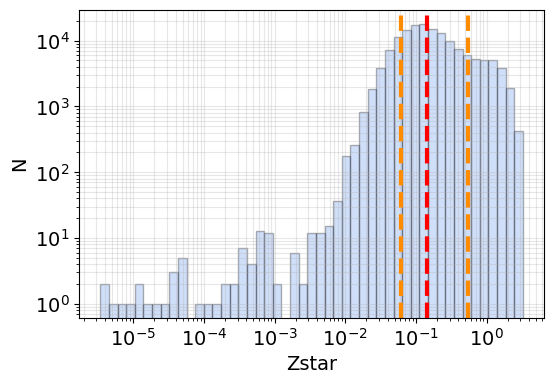

In [8]:
# Plot histogram of A_v values 

mask = Z_star > 0

median = np.median(Z_star[mask])
p16, p84 = np.percentile(Z_star[mask], [16, 84])

n_bins = 50
log_min = np.log10(Z_star[mask].min())
log_max = np.log10(Z_star[mask].max())
bins = np.logspace(log_min, log_max, n_bins)

plt.figure(figsize=(6, 4))
plt.hist(Z_star[mask], bins=bins, color='cornflowerblue', edgecolor='black', alpha=0.3)
plt.xlabel(r"Zstar")
plt.ylabel("N")
plt.yscale('log')
plt.xscale('log')
plt.grid(alpha=0.3, which='both')  # grid for both major/minor ticks

plt.axvline(median, color='red', linestyle='--', linewidth=3, label='Median')
plt.axvline(p16, color='darkorange', linestyle='--', linewidth=3, label='16th & 84th percentiles')
plt.axvline(p84, color='darkorange', linestyle='--', linewidth=3)

plt.show()

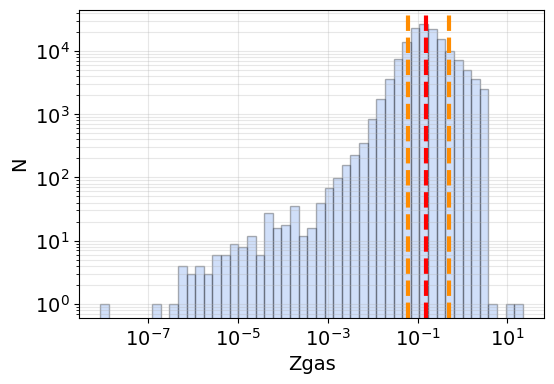

In [27]:
mask = (Z_gas > 0) & (np.isfinite(Z_gas))

median = np.median(Z_gas[mask])
p16, p84 = np.percentile(Z_gas[mask], [16, 84])

n_bins = 50
log_min = np.log10(Z_gas[mask].min())
log_max = np.log10(Z_gas[mask].max())
bins = np.logspace(log_min, log_max, n_bins)

plt.figure(figsize=(6, 4))
plt.hist(Z_gas[mask], bins=bins, color='cornflowerblue', edgecolor='black', alpha=0.3)
plt.xlabel(r"Zgas")
plt.ylabel("N")
plt.yscale('log')
plt.xscale('log')
plt.grid(alpha=0.3, which='both')  # grid for both major/minor ticks

plt.axvline(median, color='red', linestyle='--', linewidth=3, label='Median')
plt.axvline(p16, color='darkorange', linestyle='--', linewidth=3, label='16th & 84th percentiles')
plt.axvline(p84, color='darkorange', linestyle='--', linewidth=3)

plt.show()

In [106]:
# plots to make:
# 1. disk_radius vs stellar mass 
# 2. disk_radius vs L_UV 
# 3. gas fraction = gas_mass / stellar_mass vs stellar_mass
# 4. MZR: Z_gas vs stellar_mass
# 5. mdot vs sfr_100 and sfr_instantaneous
# 6. outflow_rate_mass vs stellar_mass
# 7. MS: sfr vs stellar_mass
# 8. histogram of fric_radus 
# 9. histogram of t_merger
# 10. halo_radius vs halo_mass 

# for each plot, plot all galaxy values and then also for galaxies with Av > 100
# plot scatter points where the color indicates the density of points 

/tmp/ipykernel_2278099/4134125557.py:46: RuntimeWarning: divide by zero encountered in log10
  arr2_highAv = np.log10(Z_gas[high_mask])


n TNG: 20411 points
n Salim+18: 29138 points
arr2_obs min/max: -1.67 / 1.58
arr2_TNG min/max: -0.69 / 0.84
arr1_obs min/max: 8.04 / 12.42
arr1_TNG min/max: 9.00 / 12.74
arr2_my min/max: -8.06 / 1.35
arr1_my min/max: 2.97 / 12.12


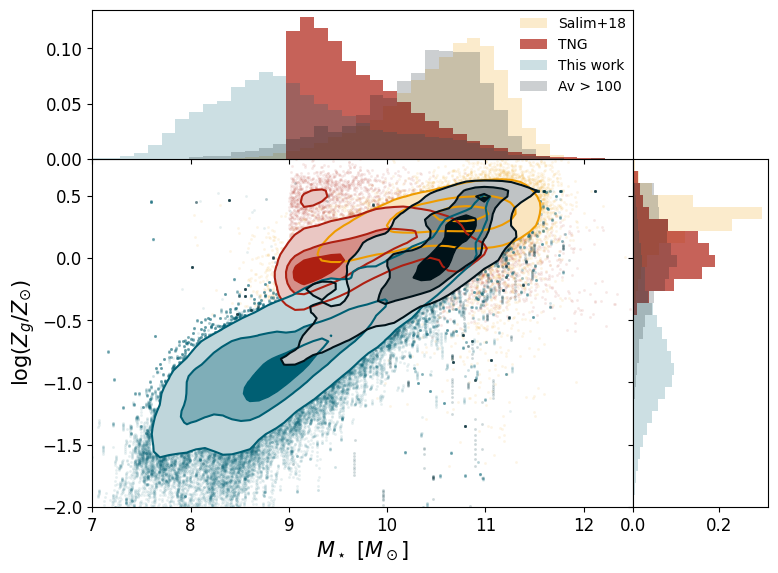

In [63]:
# --- TNG data ---
ids_50, mstar_50, gas_mass_50, sfr_50, sfr_compact_50, gas_Z_50, rstar_50, rgas_50 = np.loadtxt(
    '/mnt/home/snewman/ceph/laura/TNG/all_galaxy_properties_snap_93.dat', delimiter=',', unpack=True)
ids_100, mstar_100, gas_mass_100, sfr_100, sfr_compact_100, gas_Z_100, rstar_100, rgas_100 = np.loadtxt(
    '/mnt/home/snewman/ceph/laura/TNG/tng100_all_galaxy_properties_snap_93.dat', delimiter=',', unpack=True)

# Combine TNG50 + TNG100
mstar_TNG = np.append(mstar_50, mstar_100)
gasZ_TNG  = np.append(gas_Z_50, gas_Z_100)

# --- Salim+18 data ---
RA_S18, dec_S18, logOH_gas_S18, log_age_S18, log_mstar_S18, log_SFR_S18, \
log_Sigma_opt_S18, log_Sigma_FUV_S18, log_Sigma_NUV_S18, reff_S18, AV_S18, \
delta_S18, bump_S18 = np.loadtxt(
    '/mnt/home/snewman/ceph/laura/Salim18_data_for_laura_dis.txt',
    unpack=True)

def mask_positive_and_finite(arr):
    """Return mask for positive and finite elements."""
    return (arr > 0) & np.isfinite(arr)

# Mask obs data and convert 12+log(O/H) -> Z/Zsun
bad_val = -99
mask_obs = mask_positive_and_finite(logOH_gas_S18) & mask_positive_and_finite(logOH_gas_S18) 
logOH_gas_S18 = logOH_gas_S18[mask_obs]
log_mstar_S18 = log_mstar_S18[mask_obs]
Z_gas_S18 = 10**(logOH_gas_S18 - 8.69) # Z/Zsolar
arr1_obs = log_mstar_S18
arr2_obs = np.log10(Z_gas_S18) 

# Mask TNG data and convert to log(Z/Zsun)
mask_TNG = mask_positive_and_finite(mstar_TNG) & mask_positive_and_finite(gasZ_TNG)
mstar_TNG_clean = mstar_TNG[mask_TNG]
gasZ_TNG_clean  = gasZ_TNG[mask_TNG]
arr1_TNG = mstar_TNG_clean
arr2_TNG = np.log10(gasZ_TNG_clean / Zsole)

# My SAM data
mask_mydata = (Z_gas > 0) & np.isfinite(Z_gas) & np.isfinite(stellar_mass)
arr1_my = np.log10(stellar_mass[mask_mydata])
arr2_my = np.log10(Z_gas[mask_mydata])

# SAM data with high Av values
high_mask = Av_values > 100
arr1_highAv = np.log10(stellar_mass[high_mask])
arr2_highAv = np.log10(Z_gas[high_mask])

print(f"n TNG: {len(arr1_TNG)} points")
print(f"n Salim+18: {len(arr1_obs)} points")
print(f"arr2_obs min/max: {arr2_obs.min():.2f} / {arr2_obs.max():.2f}")
print(f"arr2_TNG min/max: {arr2_TNG.min():.2f} / {arr2_TNG.max():.2f}")
print(f"arr1_obs min/max: {arr1_obs.min():.2f} / {arr1_obs.max():.2f}")
print(f"arr1_TNG min/max: {arr1_TNG.min():.2f} / {arr1_TNG.max():.2f}")
print(f"arr2_my min/max: {arr2_my.min():.2f} / {arr2_my.max():.2f}")
print(f"arr1_my min/max: {arr1_my.min():.2f} / {arr1_my.max():.2f}")

# -----------------------------
# --- Comparison plot function ---
# -----------------------------

def comparison_four_arrays(arr1_TNG, arr2_TNG, arr1_obs, arr2_obs,
                         label_x, label_y,
                         llim_x, ulim_x, llim_y, ulim_y,
                         arr1_mydata=None, arr2_mydata=None,
                         arr1_mydata2=None, arr2_mydata2=None):
    """
    Compare TNG vs Observations vs Your Data.
    Now plots your data as contours + scatter.
    """
    fig = plt.figure(figsize=(8, 6))
    gs = GridSpec(2, 2, height_ratios=[3,7], width_ratios=[8,2], hspace=0., wspace=0.)
    ax = fig.add_subplot(gs[1,0])
    x_hist = fig.add_subplot(gs[0,0], sharex=ax)
    y_hist = fig.add_subplot(gs[1,1], sharey=ax)

    # --- Histograms ---
    bin_x = np.linspace(llim_x, ulim_x, 40)
    bin_y = np.linspace(llim_y, ulim_y, 30)

    # Observations
    col_obs = '#ee9b00'
    x_hist.hist(arr1_obs, bins=bin_x, alpha=0.2, color=col_obs,
                weights=np.ones_like(arr1_obs)/len(arr1_obs), label='Salim+18')
    y_hist.hist(arr2_obs, bins=bin_y, alpha=0.2, color=col_obs,
                weights=np.ones_like(arr2_obs)/len(arr2_obs), orientation='horizontal')

    # TNG
    col_tng = '#ae2012'
    x_hist.hist(arr1_TNG, bins=bin_x, alpha=0.7, color=col_tng,
                weights=np.ones_like(arr1_TNG)/len(arr1_TNG), label='TNG')
    y_hist.hist(arr2_TNG, bins=bin_y, alpha=0.7, color=col_tng,
                weights=np.ones_like(arr2_TNG)/len(arr2_TNG), orientation='horizontal')

    # --- Corner 2D histograms ---
    limits = [(llim_x, ulim_x), (llim_y, ulim_y)]
    corner.hist2d(arr1_obs, arr2_obs, bins=60, smooth=1.0, color=col_obs,
                  levels=[0.16, 0.5, 0.84], histtype='stepfilled', fill_contours=True,
                  range=limits, ax=ax, alpha=0.4)
    corner.hist2d(arr1_TNG, arr2_TNG, bins=60, smooth=1.0, color=col_tng,
                  levels=[0.16, 0.5, 0.84], histtype='stepfilled', fill_contours=True,
                  range=limits, ax=ax, alpha=0.3)
    
    # My data 
    if arr1_mydata is not None and arr2_mydata is not None:
        col_my = '#005f73'
        x_hist.hist(arr1_mydata, bins=bin_x, alpha=0.2, color=col_my,
                weights=np.ones_like(arr1_mydata)/len(arr1_mydata), label='This work')
        y_hist.hist(arr2_mydata, bins=bin_y, alpha=0.2, color=col_my,
                weights=np.ones_like(arr2_mydata)/len(arr2_mydata), orientation='horizontal') #histtype='step'
        corner.hist2d(arr1_mydata, arr2_mydata, bins=60, smooth=1.0, color=col_my,
                  levels=[0.16, 0.5, 0.84], histtype='stepfilled', fill_contours=True,
                  range=limits, ax=ax, alpha=0.4)
        
    # My high Av data
    if arr1_mydata2 is not None and arr2_mydata2 is not None:
        col_my2 = "#001219"
        x_hist.hist(arr1_mydata2, bins=bin_x, alpha=0.2, color=col_my2,
                weights=np.ones_like(arr1_mydata2)/len(arr1_mydata2), label='Av > 100')
        y_hist.hist(arr2_mydata2, bins=bin_y, alpha=0.2, color=col_my2,
                weights=np.ones_like(arr2_mydata2)/len(arr2_mydata2), orientation='horizontal') #histtype='step'
        corner.hist2d(arr1_mydata2, arr2_mydata2, bins=60, smooth=1.0, color=col_my2,
                  levels=[0.16, 0.5, 0.84], histtype='stepfilled', fill_contours=True,
                  range=limits, ax=ax, alpha=0.4)

    # --- Labels and limits ---
    ax.set_xlabel(label_x, fontsize=15)
    ax.set_ylabel(label_y, fontsize=15)
    ax.set_xlim(llim_x, ulim_x)
    ax.set_ylim(llim_y, ulim_y)

    # Formatting
    for a in fig.get_axes():
        a.label_outer()
        a.tick_params(axis='both', which='major', labelsize=12)

    x_hist.legend(fontsize=10, loc=(0.78,0.4), frameon=False)
    plt.tight_layout()
    plt.show()


# -----------------------------
# --- Run comparison ---
# -----------------------------

comparison_four_arrays(
    arr1_TNG=arr1_TNG,
    arr2_TNG=arr2_TNG,
    arr1_obs=arr1_obs,
    arr2_obs=arr2_obs,
    arr1_mydata=arr1_my,   # Optional: your own data
    arr2_mydata=arr2_my,
    arr1_mydata2=arr1_highAv,
    arr2_mydata2=arr2_highAv,
    label_x=r'$M_\star\ [M_\odot]$',
    label_y=r'$\log(Z_{g}/Z_{\odot})$',
    llim_x=7,
    ulim_x=12.5,
    llim_y=-2,
    ulim_y=0.8
)

Data starts at line: 41
9.8 11.54
0.035 15.261


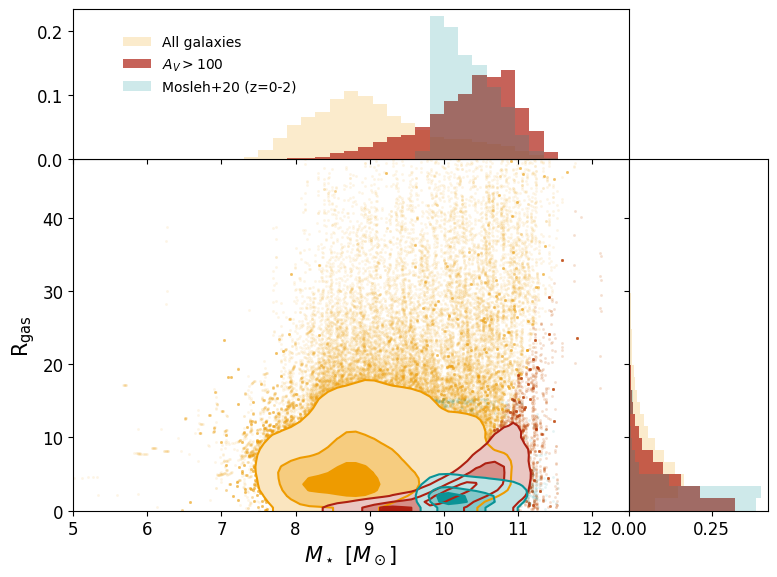

In [128]:
# Get observational data 

# Path to your file
file_path = "/mnt/home/snewman/ceph/laura/Galaxy_sizes/Mosleh20_z0-2_raw.txt"

with open(file_path) as f:
    for i, line in enumerate(f):
        if line.strip() and line.split()[0].isdigit():
            print("Data starts at line:", i)
            break

df = pd.read_csv(
    file_path,
    sep=r"\s+",
    comment="#",
    header=None,
    skiprows=41,
    names=[
        "Number", "Field", "RAdeg", "DEdeg", "z", "logM",
        "nMI", "e_nMI", "r50MI", "e_r50MI", "r20MI", "e_r20MI",
        "r80MI", "e_r80MI", "fMI",
        "nMII", "e_nMII", "q", "e_q",
        "r50MII", "e_r50MII", "r20MII", "e_r20MII",
        "r80MII", "e_r80MII", "fMII"
    ],
    skip_blank_lines=True,
    on_bad_lines="skip"   # 👈 skip any non-numeric or malformed lines
)

# Extract arrays
stellar_mass_obs = df["logM"].to_numpy()      # log stellar mass (log10(M*/Msun))
half_mass_radius_obs = df["r50MI"].to_numpy() # half-mass radius (kpc)

# Get rid of missing (=-1) values
mask = (stellar_mass_obs > 0) & (half_mass_radius_obs > 0) 
stellar_mass_obs = stellar_mass_obs[mask]
half_mass_radius_obs = half_mass_radius_obs[mask]

print(min(stellar_mass_obs), max(stellar_mass_obs))
print(min(half_mass_radius_obs), max(half_mass_radius_obs))





def comparison_two_arrays(arrx_1, arry_1, arrx_2, arry_2,
                         label_x, label_y, label1, label2,
                         llim_x, ulim_x, llim_y, ulim_y):
    """
    Compare two arrays, plotting contours, scatter and histograms.
    """
    fig = plt.figure(figsize=(8, 6))
    gs = GridSpec(2, 2, height_ratios=[3,7], width_ratios=[8,2], hspace=0., wspace=0.)
    ax = fig.add_subplot(gs[1,0])
    x_hist = fig.add_subplot(gs[0,0], sharex=ax)
    y_hist = fig.add_subplot(gs[1,1], sharey=ax)

    # --- Histograms ---
    bin_x = np.linspace(llim_x, ulim_x, 40)
    bin_y = np.linspace(llim_y, ulim_y, 30)

    # Observations
    col1 = '#ee9b00'
    x_hist.hist(arrx_1, bins=bin_x, alpha=0.2, color=col1,
                weights=np.ones_like(arrx_1)/len(arrx_1), label=label1)
    y_hist.hist(arry_1, bins=bin_y, alpha=0.2, color=col1,
                weights=np.ones_like(arry_1)/len(arry_1), orientation='horizontal')

    # TNG
    col2 = '#ae2012'
    x_hist.hist(arrx_2, bins=bin_x, alpha=0.7, color=col2,
                weights=np.ones_like(arrx_2)/len(arrx_2), label=label2)
    y_hist.hist(arry_2, bins=bin_y, alpha=0.7, color=col2,
                weights=np.ones_like(arry_2)/len(arry_2), orientation='horizontal')

    # --- Corner 2D histograms ---
    limits = [(llim_x, ulim_x), (llim_y, ulim_y)]
    corner.hist2d(arrx_1, arry_1, bins=60, smooth=1.0, color=col1,
                  levels=[0.16, 0.5, 0.84], histtype='stepfilled', fill_contours=True,
                  range=limits, ax=ax, alpha=0.4)
    corner.hist2d(arrx_2, arry_2, bins=60, smooth=1.0, color=col2,
                  levels=[0.16, 0.5, 0.84], histtype='stepfilled', fill_contours=True,
                  range=limits, ax=ax, alpha=0.3)
    
    # Add obs data 
    col_obs = '#0a9396'
    label_obs = 'Mosleh+20 (z=0-2)'
    x_hist.hist(stellar_mass_obs, bins=bin_x, alpha=0.2, color=col_obs,
                weights=np.ones_like(stellar_mass_obs)/len(stellar_mass_obs), label=label_obs)
    y_hist.hist(half_mass_radius_obs, bins=bin_y, alpha=0.2, color=col_obs,
                weights=np.ones_like(half_mass_radius_obs)/len(half_mass_radius_obs), orientation='horizontal')
    corner.hist2d(stellar_mass_obs, half_mass_radius_obs, bins=60, smooth=1.0, color=col_obs,
                  levels=[0.16, 0.5, 0.84], histtype='stepfilled', fill_contours=True,
                  range=limits, ax=ax, alpha=0.4)


   
    # --- Labels and limits ---
    ax.set_xlabel(label_x, fontsize=15)
    ax.set_ylabel(label_y, fontsize=15)
    ax.set_xlim(llim_x, ulim_x)
    ax.set_ylim(llim_y, ulim_y)

    # Formatting
    for a in fig.get_axes():
        a.label_outer()
        a.tick_params(axis='both', which='major', labelsize=12)

    x_hist.legend(fontsize=10, loc=(0.08,0.4), frameon=False)
    plt.tight_layout()
    plt.show()





# -----------------------------
# --- Run comparison ---
# -----------------------------

high_mask = Av_values > 100

comparison_two_arrays(
    arrx_1=np.log10(stellar_mass),
    arry_1=gas_radius,
    arrx_2=np.log10(stellar_mass[high_mask]),
    arry_2=gas_radius[high_mask],
    label_x=r'$M_\star\ [M_\odot]$',
    label_y=r'$\rm R_{gas}$',
    label1 = 'All galaxies',
    label2 = r'$A_V > 100$',
    llim_x=5,
    ulim_x=12.5,
    llim_y=0,
    ulim_y=48
)

0.0 212977.47
4.692858e-11 212977.47
x_logMstar: [ 9.156  9.435  9.747 10.052 10.341 10.65  10.949 11.211]
logHIfrac: [ 0.147  0.04  -0.515 -0.491 -0.789 -0.968 -1.243 -1.499]


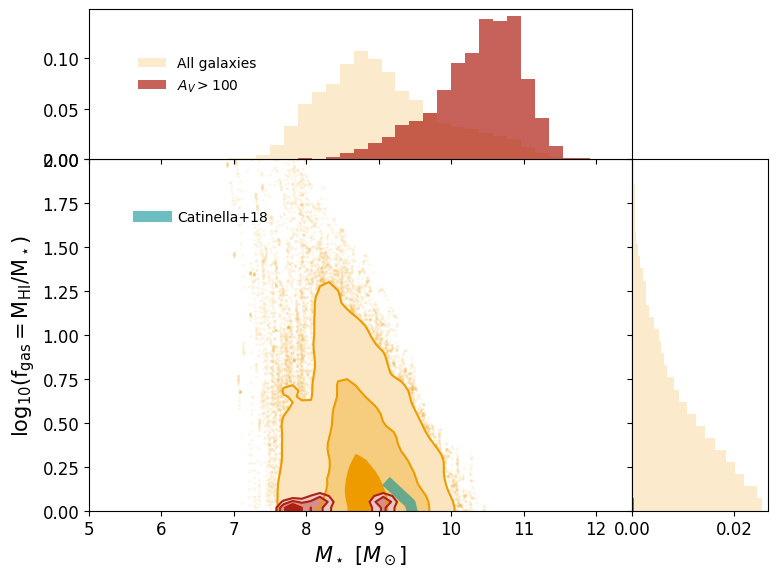

6.134432e-10 1.1054393


In [167]:
mask = mask_positive_and_finite(stellar_mass) & mask_positive_and_finite(hi_mass) & (hi_mass > 1e-6)
high_mask = (Av_values > 100) & mask

f_gas = hi_mass/(stellar_mass)

print(f_gas.min(), f_gas.max())
print(f_gas[mask].min(), f_gas[mask].max())

# Get obs data

file_path = "/mnt/home/snewman/ceph/laura/ZZZ -- Old Draft/GalaxyColdGasMassStellarMass/Catinella2018.txt"  

# Prepare storage for different blocks
data_blocks = {}
current_label = None
current_data = []

with open(file_path, "r") as f:
    for line in f:
        line = line.strip()
        if not line or line.startswith("#"):
            # Detect new section labels
            if "x =" in line:
                if current_label and current_data:
                    # Save previous block
                    arr = np.array(current_data, dtype=float)
                    data_blocks[current_label] = arr
                    current_data = []
                current_label = line.split("x =")[1].strip()
            continue
        
        # Regular numeric line: two columns
        parts = line.split()
        if len(parts) == 2:
            current_data.append([float(parts[0]), float(parts[1])])

# Save the last block
if current_label and current_data:
    data_blocks[current_label] = np.array(current_data, dtype=float)

# Now you have arrays for each block
# For example, stellar mass vs HI fraction:
obs_logMstar = data_blocks["log Mstar/Msun"][:,0]      # x-axis: log Mstar
obs_logHIfrac = data_blocks["log Mstar/Msun"][:,1]      # y-axis: avg log(MHI/Mstar)

# Print arrays
print("x_logMstar:", obs_logMstar)
print("logHIfrac:", obs_logHIfrac)



def comparison_two_arrays(arrx_1, arry_1, arrx_2, arry_2,
                         label_x, label_y, label1, label2,
                         llim_x, ulim_x, llim_y, ulim_y):
    """
    Compare two arrays, plotting contours, scatter and histograms.
    """
    fig = plt.figure(figsize=(8, 6))
    gs = GridSpec(2, 2, height_ratios=[3,7], width_ratios=[8,2], hspace=0., wspace=0.)
    ax = fig.add_subplot(gs[1,0])
    x_hist = fig.add_subplot(gs[0,0], sharex=ax)
    y_hist = fig.add_subplot(gs[1,1], sharey=ax)

    # --- Histograms ---
    bin_x = np.linspace(llim_x, ulim_x, 40)
    bin_y = np.linspace(llim_y, ulim_y, 30)

    # Array 1
    col1 = '#ee9b00'
    x_hist.hist(arrx_1, bins=bin_x, alpha=0.2, color=col1,
                weights=np.ones_like(arrx_1)/len(arrx_1), label=label1)
    y_hist.hist(arry_1, bins=bin_y, alpha=0.2, color=col1,
                weights=np.ones_like(arry_1)/len(arry_1), orientation='horizontal')

    # Array 2 
    col2 = '#ae2012'
    x_hist.hist(arrx_2, bins=bin_x, alpha=0.7, color=col2,
                weights=np.ones_like(arrx_2)/len(arrx_2), label=label2)
    y_hist.hist(arry_2, bins=bin_y, alpha=0.7, color=col2,
                weights=np.ones_like(arry_2)/len(arry_2), orientation='horizontal')

    # --- Corner 2D histograms ---
    limits = [(llim_x, ulim_x), (llim_y, ulim_y)]
    corner.hist2d(arrx_1, arry_1, bins=60, smooth=1.0, color=col1,
                  levels=[0.16, 0.5, 0.84], histtype='stepfilled', fill_contours=True,
                  range=limits, ax=ax, alpha=0.4)
    corner.hist2d(arrx_2, arry_2, bins=60, smooth=1.0, color=col2,
                  levels=[0.16, 0.5, 0.84], histtype='stepfilled', fill_contours=True,
                  range=limits, ax=ax, alpha=0.3)
    
    # Add obs data 
    col_obs = '#0a9396'
    label_obs = 'Catinella+18'
    x_obs = obs_logMstar
    y_obs = obs_logHIfrac
    ax.plot(x_obs, y_obs, color=col_obs, lw=8, alpha=0.6, label=label_obs)
    ax.legend(fontsize=10, loc=(0.08,0.8), frameon=False)
    
    # --- Labels and limits ---
    ax.set_xlabel(label_x, fontsize=15)
    ax.set_ylabel(label_y, fontsize=15)
    ax.set_xlim(llim_x, ulim_x)
    ax.set_ylim(llim_y, ulim_y)

    # Formatting
    for a in fig.get_axes():
        a.label_outer()
        a.tick_params(axis='both', which='major', labelsize=12)

    x_hist.legend(fontsize=10, loc=(0.08,0.4), frameon=False)
    plt.tight_layout()
    plt.show()

comparison_two_arrays(
    arrx_1=np.log10(stellar_mass[mask]),
    arry_1=np.log10(f_gas[mask]),
    arrx_2=np.log10(stellar_mass[high_mask]),
    arry_2=np.log10(f_gas[high_mask]),
    label_x=r'$M_\star\ [M_\odot]$',
    label_y=r'$\rm log_{10}(f_{gas} = M_{HI}/M_\star$)',
    label1 = 'All galaxies',
    label2 = r'$A_V > 100$',
    llim_x=5,
    ulim_x=12.5,
    llim_y=0,
    ulim_y=2
)

print(min(f_gas[high_mask]), max(f_gas[high_mask]))

1613 SFR <= 0
144335 Maccdot <= 0


<>:47: SyntaxWarning: invalid escape sequence '\o'
<>:69: SyntaxWarning: invalid escape sequence '\o'
<>:47: SyntaxWarning: invalid escape sequence '\o'
<>:69: SyntaxWarning: invalid escape sequence '\o'
/tmp/ipykernel_1911518/486935026.py:47: SyntaxWarning: invalid escape sequence '\o'
  ax.set_ylabel('Outflow rate [M$_\odot$/yr]')
/tmp/ipykernel_1911518/486935026.py:69: SyntaxWarning: invalid escape sequence '\o'
  ax.set_ylabel('SFR [M$_\odot$/yr]')
/tmp/ipykernel_1911518/2838801183.py:43: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.fill_between(centers, p16v, p84v, color=color, alpha=0.3)


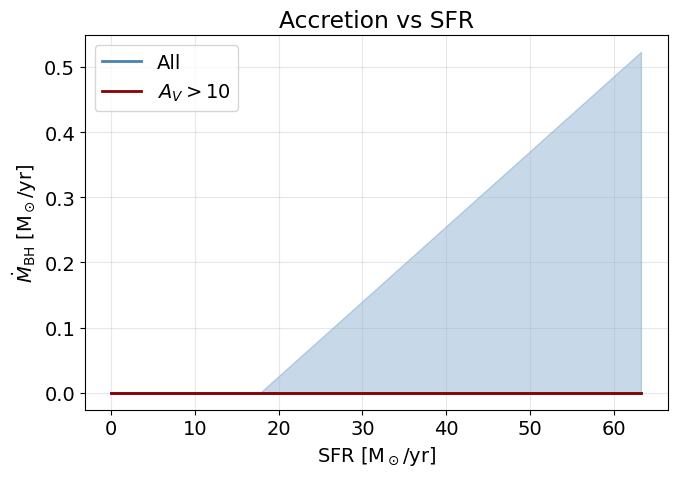

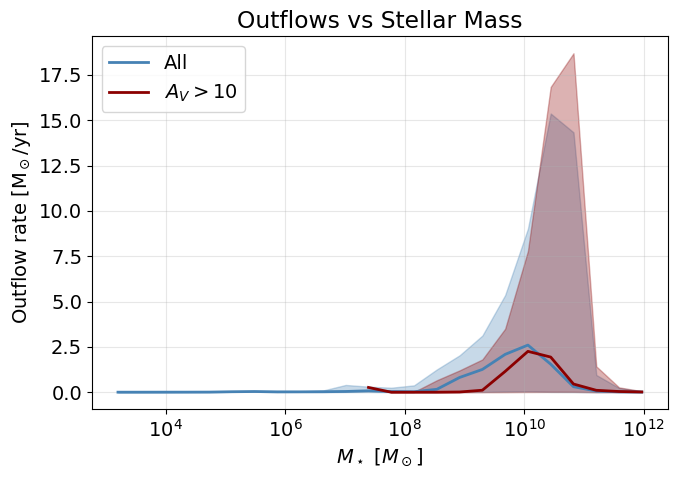

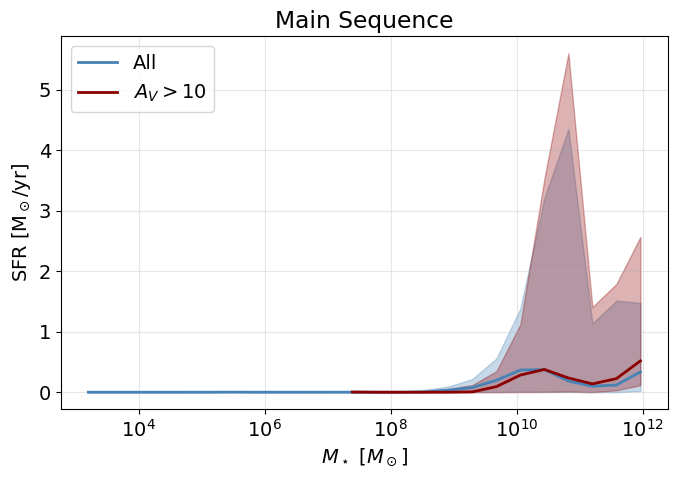

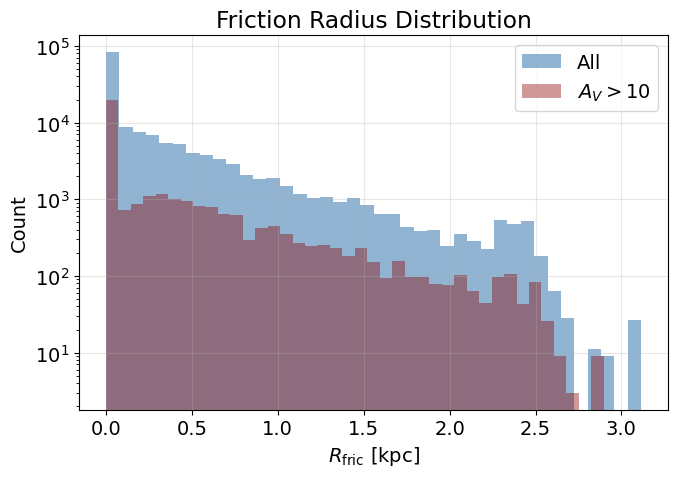

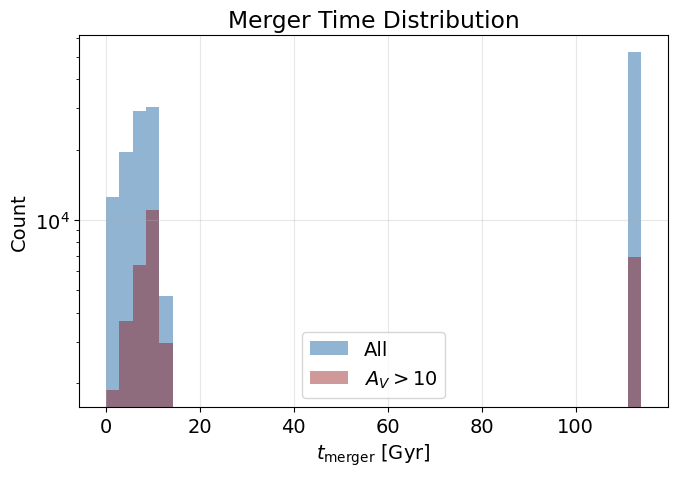

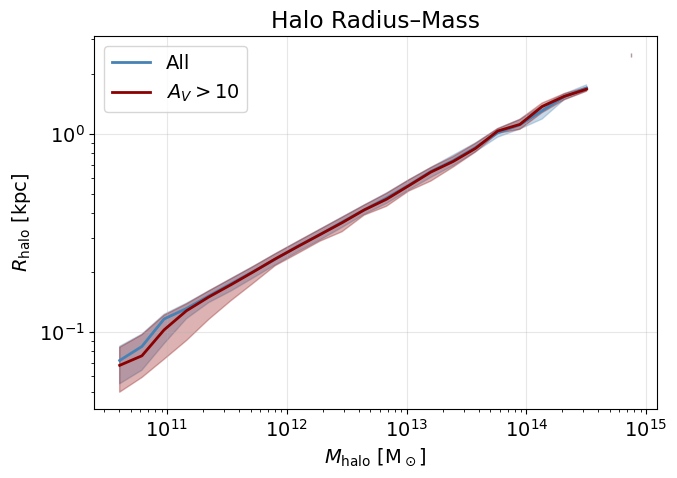

In [27]:
# --- Shared bins for different x-axes ---
mass_bins = np.logspace(np.log10(np.nanmin(stellar_mass[stellar_mass > 0])),
                        np.log10(np.nanmax(stellar_mass)), 25)
sfr_bins  = np.logspace(np.log10(np.nanmin(sfr[sfr > 0])),
                        np.log10(np.nanmax(sfr)), 25)
halo_bins = np.logspace(np.log10(np.nanmin(halo_mass[halo_mass > 0])),
                        np.log10(np.nanmax(halo_mass)), 25)

print(np.sum(sfr <= 0), "SFR <= 0")
print(np.sum(maccdot <= 0), "Maccdot <= 0")

# ---------------------------------------------------------------
# 1️⃣ Accretion vs SFR
# ---------------------------------------------------------------
fig, ax = plt.subplots(figsize=(7, 5))

x, y = sfr, maccdot
xlog = np.all(x > 0)
ylog = np.all(y > 0)

plot_median(ax, x, y, color='steelblue', label='All', bins=sfr_bins)
plot_median(ax, x[high_Av_mask], y[high_Av_mask], color='darkred', label=r'$A_V>10$', bins=sfr_bins)

ax.set_xlabel('SFR [M$_\\odot$/yr]')
ax.set_ylabel(r'$\dot{M}_{\rm BH}$ [M$_\odot$/yr]')
ax.set_xscale('log' if xlog else 'linear')
ax.set_yscale('log' if ylog else 'linear')
ax.set_title('Accretion vs SFR')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ---------------------------------------------------------------
# 2️⃣ Outflows vs Stellar Mass
# ---------------------------------------------------------------
fig, ax = plt.subplots(figsize=(7, 5))

x, y = stellar_mass, outflow_rate_mass
xlog = np.all(x > 0)
ylog = np.all(y > 0)

plot_median(ax, x, y, color='steelblue', label='All', bins=mass_bins)
plot_median(ax, x[high_Av_mask], y[high_Av_mask], color='darkred', label=r'$A_V>10$', bins=mass_bins)

ax.set_xlabel(r'$M_\star\ [M_\odot]$')
ax.set_ylabel('Outflow rate [M$_\odot$/yr]')
ax.set_xscale('log' if xlog else 'linear')
ax.set_yscale('log' if ylog else 'linear')
ax.set_title('Outflows vs Stellar Mass')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ---------------------------------------------------------------
# 3️⃣ Main Sequence (SFR vs Mstar)
# ---------------------------------------------------------------
fig, ax = plt.subplots(figsize=(7, 5))

x, y = stellar_mass, sfr
xlog = np.all(x > 0)
ylog = np.all(y > 0)

plot_median(ax, x, y, color='steelblue', label='All', bins=mass_bins)
plot_median(ax, x[high_Av_mask], y[high_Av_mask], color='darkred', label=r'$A_V>10$', bins=mass_bins)

ax.set_xlabel(r'$M_\star\ [M_\odot]$')
ax.set_ylabel('SFR [M$_\odot$/yr]')
ax.set_xscale('log' if xlog else 'linear')
ax.set_yscale('log' if ylog else 'linear')
ax.set_title('Main Sequence')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ---------------------------------------------------------------
# 4️⃣ Friction Radius Distribution
# ---------------------------------------------------------------
fig, ax = plt.subplots(figsize=(7, 5))

ax.hist(fric_radius, bins=40, alpha=0.6, color='steelblue', label='All')
ax.hist(fric_radius[high_Av_mask], bins=40, alpha=0.4, color='darkred', label=r'$A_V>10$')

ax.set_xlabel(r'$R_{\rm fric}$ [kpc]')
ax.set_ylabel('Count')
ax.set_title('Friction Radius Distribution')
ax.legend()
ax.set_yscale('log')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ---------------------------------------------------------------
# 5️⃣ Merger Time Distribution
# ---------------------------------------------------------------
fig, ax = plt.subplots(figsize=(7, 5))

ax.hist(t_merger, bins=40, alpha=0.6, color='steelblue', label='All')
ax.hist(t_merger[high_Av_mask], bins=40, alpha=0.4, color='darkred', label=r'$A_V>10$')

ax.set_xlabel(r'$t_{\rm merger}$ [Gyr]')
ax.set_ylabel('Count')
ax.set_title('Merger Time Distribution')
ax.set_yscale('log')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ---------------------------------------------------------------
# 6️⃣ Halo Radius–Mass Relation
# ---------------------------------------------------------------
fig, ax = plt.subplots(figsize=(7, 5))

x, y = halo_mass, halo_radius
xlog = np.all(x > 0)
ylog = np.all(y > 0)

plot_median(ax, x, y, color='steelblue', label='All', bins=halo_bins)
plot_median(ax, x[high_Av_mask], y[high_Av_mask], color='darkred', label=r'$A_V>10$', bins=halo_bins)

ax.set_xlabel(r'$M_{\rm halo}$ [M$_\odot]$')
ax.set_ylabel(r'$R_{\rm halo}$ [kpc]')
ax.set_xscale('log' if xlog else 'linear')
ax.set_yscale('log' if ylog else 'linear')
ax.set_title('Halo Radius–Mass')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
